In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




In [62]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/Predictive Modelling | MBAN 5110 U /Hackathon/Updated_XYZ_Sportswear_Orders_Dataset.csv')

In [63]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Value per Item
0,01.01.2009,18.02.2009,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,East,33.733750
1,01.01.2009,10.02.2009,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,West,85.170000
2,01.01.2009,17.01.2009,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,West,8.727143
3,03.01.2009,28.01.2009,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,North,41.863333
4,03.01.2009,18.01.2009,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,West,30.666000


Convert dates to datetime

In [64]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month

df['Delivery Year'] = df['Requested Delivery Date'].dt.year
df['Delivery Month'] = df['Requested Delivery Date'].dt.month

Review orders on a monthly level.

In [65]:
monthly_orders = df.groupby(['Order Year', 'Order Month']).agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
monthly_orders = monthly_orders.sort_values(by=['Order Year', 'Order Month'])

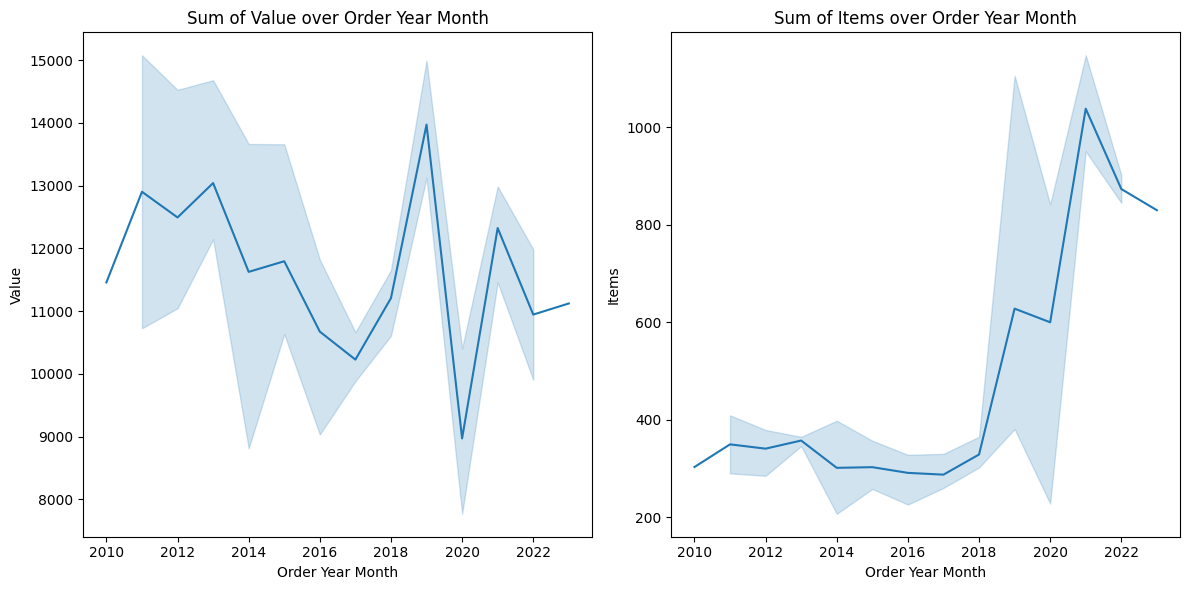

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for continuous order year month
monthly_orders['Order Year Month'] = monthly_orders['Order Year'] + monthly_orders['Order Month']

# Sort the dataframe by Order Year Month
monthly_orders = monthly_orders.sort_values('Order Year Month')

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the line plot for Value
plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_orders, x='Order Year Month', y='Value')
plt.xlabel('Order Year Month')
plt.ylabel('Value')
plt.title('Sum of Value over Order Year Month')

# Create the line plot for Items
plt.subplot(1, 2, 2)
sns.lineplot(data=monthly_orders, x='Order Year Month', y='Items')
plt.xlabel('Order Year Month')
plt.ylabel('Items')
plt.title('Sum of Items over Order Year Month')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


Review orders on a seasonal basis.

In [67]:
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# Apply the season function

df['O_Season'] = df['Order Month'].apply(month_to_season)
df['D_Season'] = df['Delivery Month'].apply(month_to_season)
df['Year-Season'] = df['Order Year'].astype(str) + '-' + df['O_Season']
df['O_Season_Num'] = df['O_Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})
df['D_Season_Num'] = df['D_Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})

# Make year and season a continuous time-sequence

year_season_orders = df.groupby('Year-Season').agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
year_season_orders['Year-Season'] = pd.Categorical(year_season_orders['Year-Season'], categories=sorted(df['Year-Season'].unique()), ordered=True)
year_season_orders = year_season_orders.sort_values('Year-Season')

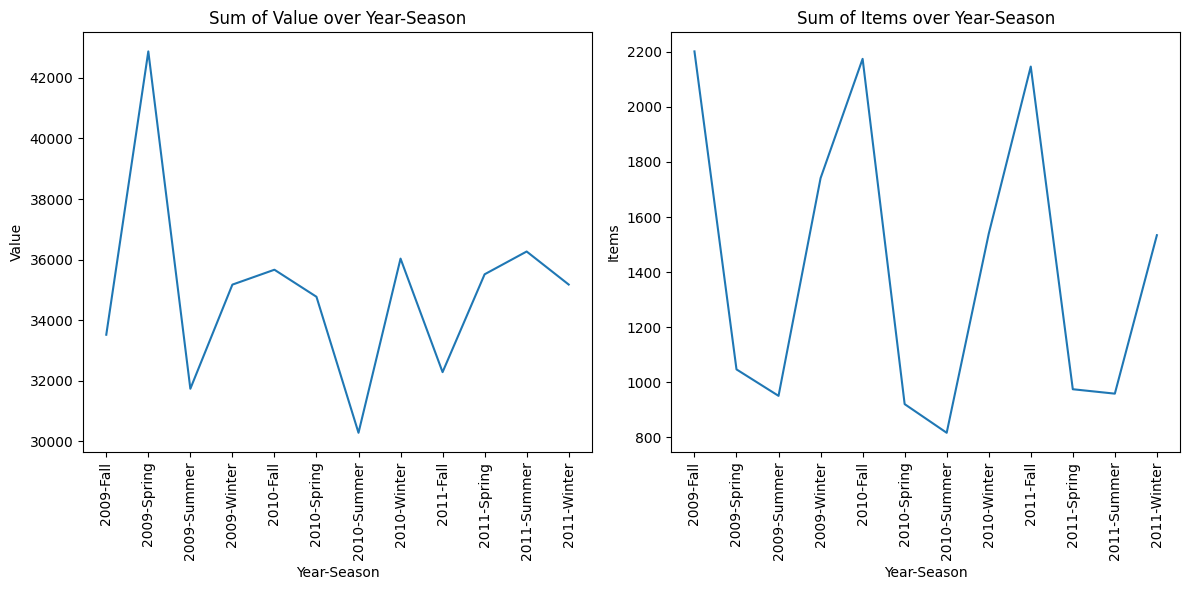

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

year_season_orders = year_season_orders.sort_values('Year-Season')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=year_season_orders, x='Year-Season', y='Value')
plt.xlabel('Year-Season')
plt.ylabel('Value')
plt.title('Sum of Value over Year-Season')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=year_season_orders, x='Year-Season', y='Items')
plt.xlabel('Year-Season')
plt.ylabel('Items')
plt.title('Sum of Items over Year-Season')
plt.xticks(rotation=90)

plt.tight_layout()


In [69]:
Grouped_D_Season = df.groupby(['Delivery Year', 'D_Season_Num']).agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
Grouped_D_Season['Delivery Year Season'] = Grouped_D_Season['Delivery Year'].astype(str) + '-' + Grouped_D_Season['D_Season_Num'].astype(str)


In [70]:
Grouped_D_Season.head()

,Delivery Year,D_Season_Num,Value,Items,Delivery Year Season
0,2009,1,23927.39,1413,2009-1
1,2009,2,38794.80,997,2009-2
2,2009,3,35804.75,926,2009-3
3,2009,4,33383.72,1613,2009-4
4,2010,1,36455.83,2278,2010-1


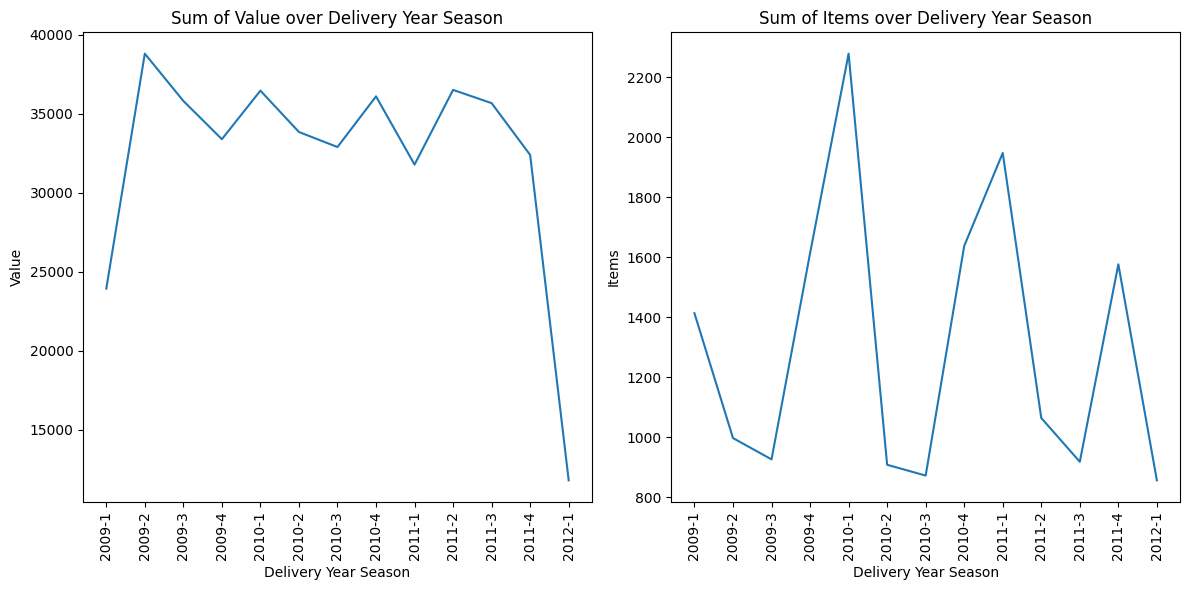

In [71]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=Grouped_D_Season, x='Delivery Year Season', y='Value')
plt.xlabel('Delivery Year Season')
plt.ylabel('Value')
plt.title('Sum of Value over Delivery Year Season')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=Grouped_D_Season, x='Delivery Year Season', y='Items')
plt.xlabel('Delivery Year Season')
plt.ylabel('Items')
plt.title('Sum of Items over Delivery Year Season')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


Calculate Lead Time in days & months, value per item, Customer_ID, give season a numerical value.

In [72]:
df['Lead_Time_Days'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days
df['Lead_Time_Months'] = (df['Delivery Year'] - df['Order Year']) * 12 + (df['Delivery Month'] - df['Order Month'])

df['Value/Item'] = df['Value'] / df['Items']

df['Customer_ID'] = df['Customer Country Code'] + '-' + df['Route']

In [73]:
product_dummies = pd.get_dummies(df['Product Code'])
df = pd.concat([df, product_dummies], axis=1)

df['advanced_order'] = (df['Lead_Time_Days'] >= 30).astype(int)
df['advanced_order_amount'] = df['Items'] * df['advanced_order']
df['urgent_order_amount'] = df['Items'] - df['advanced_order_amount']


Make Average Selection rate of product per season:

In [74]:
total_items_per_season = df.groupby('O_Season_Num')['Items'].sum()
items_per_product_season = df.groupby(['O_Season_Num', 'Product Code'])['Items'].sum().reset_index()
merged_df = pd.merge(items_per_product_season, total_items_per_season, on='O_Season_Num', suffixes=('', '_Total'))

merged_df['Selection_Rate'] = merged_df['Items'] / merged_df['Items_Total']
selection_rate_dict = merged_df.set_index(['O_Season_Num', 'Product Code'])['Selection_Rate'].to_dict()

df['Avg_Season_Selection_Rate'] = df.apply(lambda row: selection_rate_dict.get((row['O_Season_Num'], row['Product Code'])), axis=1)

Let's see how many variations in lead time months there are to determine how to categorize if an order is urgent, Advanced & Urgent, or Simply Advanced.

In [75]:
df['Lead_Time_Months'].unique()


array([1, 0, 2])

Set "Order Urgency" labels

In [76]:
df['Urgent'] = (df['Lead_Time_Months'] == 0).astype(int)
df['Advanced_Urgent'] = (df['Lead_Time_Months'] == 1).astype(int)
df['Advanced'] = (df['Lead_Time_Months'] == 2).astype(int)


Now for each row, determine the number of items orders for each level of "order urgency"

In [77]:
df['Urgent Items'] = df['Urgent'] * df['Items']
df['Advanced_Urgent_Items'] = df['Advanced_Urgent'] * df['Items']
df['Advanced_Items'] = df['Advanced'] * df['Items']


Lets save a copy of this DF, but clean the one we'll be using up a little bit.

In [78]:
df2 = df.copy()

In [79]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order Type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Value per Item', 'Order Year',
       'Order Month', 'Delivery Year', 'Delivery Month', 'O_Season',
       'D_Season', 'Year-Season', 'O_Season_Num', 'D_Season_Num',
       'Lead_Time_Days', 'Lead_Time_Months', 'Value/Item', 'Customer_ID',
       'PK001', 'PK002', 'PK003', 'PK004', 'advanced_order',
       'advanced_order_amount', 'urgent_order_amount',
       'Avg_Season_Selection_Rate', 'Urgent', 'Advanced_Urgent', 'Advanced',
       'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items'],
      dtype='object')

In [80]:
df.drop(['PK001', 'PK002', 'PK003', 'PK004', 'Description', 'Order Type', 'Currency'], axis=1, inplace=True)


In [81]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Customer Order Code', 'Value', 'Items', 'Route',
       'Value per Item', 'Order Year', 'Order Month', 'Delivery Year',
       'Delivery Month', 'O_Season', 'D_Season', 'Year-Season', 'O_Season_Num',
       'D_Season_Num', 'Lead_Time_Days', 'Lead_Time_Months', 'Value/Item',
       'Customer_ID', 'advanced_order', 'advanced_order_amount',
       'urgent_order_amount', 'Avg_Season_Selection_Rate', 'Urgent',
       'Advanced_Urgent', 'Advanced', 'Urgent Items', 'Advanced_Urgent_Items',
       'Advanced_Items'],
      dtype='object')

Reordering columns in the DataFrame to make them make more sense

In [82]:
df = df[[
    'Customer Order Code', 'Customer_ID', 'Order Date', 'Order Year', 'Order Month','O_Season', 'O_Season_Num',
    'Requested Delivery Date', 'Delivery Year', 'Delivery Month', 'D_Season', 'D_Season_Num', 'Year-Season',
    'Lead_Time_Days', 'Lead_Time_Months', 'Items', 'Value', 'Value per Item', 'Value/Item',
    'Route', 'Product Code', 'Customer Country Code', 'advanced_order',
    'advanced_order_amount', 'urgent_order_amount', 'Urgent', 'Advanced_Urgent', 'Advanced',
    'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'Avg_Season_Selection_Rate'
]]


In [83]:
df.head()

,Customer Order Code,Customer_ID,Order Date,Order Year,Order Month,O_Season,O_Season_Num,Requested Delivery Date,Delivery Year,Delivery Month,...,advanced_order,advanced_order_amount,urgent_order_amount,Urgent,Advanced_Urgent,Advanced,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Avg_Season_Selection_Rate
0,COD00001,DE-East,2009-01-01,2009,1,Winter,1,2009-02-18,2009,2,...,1,8,0,0,1,0,0,8,0,0.249896
1,COD00002,FR-West,2009-01-01,2009,1,Winter,1,2009-02-10,2009,2,...,1,2,0,0,1,0,0,2,0,0.272954
2,COD00003,ES-West,2009-01-01,2009,1,Winter,1,2009-01-17,2009,1,...,0,0,7,1,0,0,7,0,0,0.248027
3,COD00004,IT-North,2009-01-03,2009,1,Winter,1,2009-01-28,2009,1,...,0,0,6,1,0,0,6,0,0,0.249896
4,COD00005,DE-West,2009-01-03,2009,1,Winter,1,2009-01-18,2009,1,...,0,0,5,1,0,0,5,0,0,0.229123


In [84]:
df_month_lead = df.groupby(['Order Year', 'Order Month']).agg({'O_Season_Num':'max', 'Items': 'sum', 'Urgent Items': 'sum', 'Advanced_Urgent_Items': 'sum', 'Advanced_Items': 'sum'}).reset_index()


In [85]:
df_month_lead.head()

,Order Year,Order Month,O_Season_Num,Items,Urgent Items,Advanced_Urgent_Items,Advanced_Items
0,2009,1,1,303,68,144,91
1,2009,2,1,290,131,103,56
2,2009,3,2,379,79,204,96
3,2009,4,2,369,48,246,75
4,2009,5,2,299,74,146,79


In [86]:
df_demand_delivery = df.groupby([ 'Delivery Year', 'Delivery Month']).agg({'D_Season_Num':'max', 'Items': 'sum'}).reset_index()


In [87]:
df_demand_delivery = df_demand_delivery.sort_values(by=['Delivery Year', 'Delivery Month'])


In [88]:
df_demand_delivery

,Delivery Year,Delivery Month,D_Season_Num,Items
0,2009,1,1,68
1,2009,2,1,275
2,2009,3,2,273
3,2009,4,2,308
4,2009,5,2,416
5,2009,6,3,297
6,2009,7,3,356
7,2009,8,3,273
8,2009,9,4,312
9,2009,10,4,612


In [89]:
combined_df = pd.merge(df_month_lead, df_demand_delivery, left_on=['Order Year', 'Order Month'], right_on=['Delivery Year', 'Delivery Month'], how='inner')


In [90]:
combined_df = combined_df.rename(columns={'Items_x': 'ordered_items', 'Items_y': 'item_demand'})

In [91]:
combined_df['Urgent_Items_prev_month'] = combined_df['Urgent Items'].shift(1)
combined_df['Advanced_Urgent_Items_prev_month'] = combined_df['Advanced_Urgent_Items'].shift(1)
combined_df['Advanced_Items_2_months_ago'] = combined_df['Advanced_Items'].shift(2)


In [92]:
combined_df.head(10)

,Order Year,Order Month,O_Season_Num,ordered_items,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Delivery Year,Delivery Month,D_Season_Num,item_demand,Urgent_Items_prev_month,Advanced_Urgent_Items_prev_month,Advanced_Items_2_months_ago
0,2009,1,1,303,68,144,91,2009,1,1,68,NaN,NaN,NaN
1,2009,2,1,290,131,103,56,2009,2,1,275,68.0,144.0,NaN
2,2009,3,2,379,79,204,96,2009,3,2,273,131.0,103.0,91.0
3,2009,4,2,369,48,246,75,2009,4,2,308,79.0,204.0,56.0
4,2009,5,2,299,74,146,79,2009,5,2,416,48.0,246.0,96.0
5,2009,6,3,293,76,172,45,2009,6,3,297,74.0,146.0,75.0
6,2009,7,3,328,105,138,85,2009,7,3,356,76.0,172.0,79.0
7,2009,8,3,330,90,137,103,2009,8,3,273,105.0,138.0,45.0
8,2009,9,4,365,90,201,74,2009,9,4,312,90.0,137.0,85.0
9,2009,10,4,1106,308,495,303,2009,10,4,612,90.0,201.0,103.0


**I will now predict the choice probabilities of each product getting selected for an order**

Per row calculation (no aggregation)

In [93]:
features = ['O_Season_Num', 'D_Season_Num','Order Year', 'Customer Country Code', 'Route', 'Order Month', 'Delivery Month', 'Delivery Year', 'Lead_Time_Days', 'Avg_Season_Selection_Rate', 'Items', 'Value', 'Value/Item','Lead_Time_Months', 'Urgent',
       'Advanced_Urgent', 'Advanced', 'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'advanced_order']

X = df[features]
y = df['Product Code']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['O_Season_Num', 'D_Season_Num', 'Customer Country Code', 'Route', 'Order Year', 'Delivery Year', 'Lead_Time_Months']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['Lead_Time_Days', 'Avg_Season_Selection_Rate', 'Items', 'Value/Item', 'Urgent Items', 'Advanced_Urgent_Items',
       'Advanced_Items']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)
model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

Log Loss: 1.3905


In [96]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

probabilities = model.predict_proba(X)

prob_cols = [f'prob_{code}' for code in le.classes_]
df_probs = pd.DataFrame(probabilities, columns=prob_cols, index=X.index)

df_with_probs = df.join(df_probs)

seasonal_choice_probabilities = df_with_probs.groupby('O_Season_Num')[prob_cols].mean()

print(seasonal_choice_probabilities)


Accuracy: 0.2577
              prob_PK001  prob_PK002  prob_PK003  prob_PK004
O_Season_Num                                                
1               0.259297    0.235113    0.259113    0.246476
2               0.269208    0.259178    0.239519    0.232096
3               0.212815    0.281937    0.224355    0.280893
4               0.263655    0.225561    0.258498    0.252287


I want to see if aggregating by month before calculating choise probabilities helps improve the calculation. I'll do that here:

In [97]:
product_monthly_df = df.groupby(['Order Year', 'Order Month', 'O_Season_Num', 'Product Code']).agg({'Items': 'sum', 'Value': 'sum', 'Value/Item': 'mean', 'Urgent Items': 'sum', 'Advanced_Urgent_Items': 'sum', 'Advanced_Items': 'sum', 'Lead_Time_Months': 'mean'}).reset_index()
product_monthly_df.head()

,Order Year,Order Month,O_Season_Num,Product Code,Items,Value,Value/Item,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Lead_Time_Months
0,2009,1,1,PK001,83,2763.86,56.283453,14,57,12,0.933333
1,2009,1,1,PK002,64,2466.34,50.702885,14,3,47,1.538462
2,2009,1,1,PK003,100,4353.44,68.637064,21,47,32,1.142857
3,2009,1,1,PK004,56,1874.78,44.528570,19,37,0,0.700000
4,2009,2,1,PK001,64,2662.96,79.417666,35,4,25,0.923077


In [98]:
le = LabelEncoder()
product_monthly_df['Product Num'] = le.fit_transform(product_monthly_df['Product Code'])


In [99]:
features = ['Order Year', 'Order Month', 'Items', 'Value', 'Value/Item', 
            'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'Lead_Time_Months', 'O_Season_Num']

X = product_monthly_df[features]
y = product_monthly_df['Product Num']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['Order Year', 'Order Month', 'O_Season_Num']
numerical_features = ['Items', 'Value', 'Value/Item', 'Urgent Items', 
                      'Advanced_Urgent_Items', 'Advanced_Items', 'Lead_Time_Months']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)


log_loss_value = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 1.6472


In [100]:
y_pred = model.predict(X_test)
accuracy_value = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_value:.4f}')

prob_df = pd.DataFrame(y_pred_probs, columns=model.named_steps['classifier'].classes_)

prob_df['O_Season_Num'] = X_test['O_Season_Num'].values
prob_df['Actual_Product_Num'] = y_test.values

choice_probabilities = prob_df.groupby('O_Season_Num').mean()

choice_probabilities = choice_probabilities.rename(columns={0: 'prob_PK001', 1: 'prob_PK002', 2: 'prob_PK003', 3: 'prob_PK004'})
print(choice_probabilities)


print(choice_probabilities)


Accuracy: 0.0345
              prob_PK001  prob_PK002  prob_PK003  prob_PK004  \
O_Season_Num                                                   
1               0.280510    0.218238    0.278041    0.223211   
2               0.281124    0.239812    0.212432    0.266632   
3               0.286563    0.191829    0.264978    0.256630   
4               0.179292    0.197497    0.306128    0.317083   

              Actual_Product_Num  
O_Season_Num                      
1                       1.428571  
2                       1.363636  
3                       1.750000  
4                       1.000000  
              prob_PK001  prob_PK002  prob_PK003  prob_PK004  \
O_Season_Num                                                   
1               0.280510    0.218238    0.278041    0.223211   
2               0.281124    0.239812    0.212432    0.266632   
3               0.286563    0.191829    0.264978    0.256630   
4               0.179292    0.197497    0.306128    0.317083   

   

**I will now look to create my future month demand forecast based on advanced orders in my combined dataframe**

In [101]:
combined_df['Advanced_Combined'] = combined_df['Advanced_Urgent_Items_prev_month'] + combined_df['Advanced_Items_2_months_ago']

In [102]:
combined_df.head()

,Order Year,Order Month,O_Season_Num,ordered_items,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Delivery Year,Delivery Month,D_Season_Num,item_demand,Urgent_Items_prev_month,Advanced_Urgent_Items_prev_month,Advanced_Items_2_months_ago,Advanced_Combined
0,2009,1,1,303,68,144,91,2009,1,1,68,NaN,NaN,NaN,NaN
1,2009,2,1,290,131,103,56,2009,2,1,275,68.0,144.0,NaN,NaN
2,2009,3,2,379,79,204,96,2009,3,2,273,131.0,103.0,91.0,194.0
3,2009,4,2,369,48,246,75,2009,4,2,308,79.0,204.0,56.0,260.0
4,2009,5,2,299,74,146,79,2009,5,2,416,48.0,246.0,96.0,342.0


Remove the first two months as they have NA values, so predictions can only be made by the 3rd month.

In [103]:
comdined_df_copy = combined_df.copy()
combined_df.dropna(inplace=True)


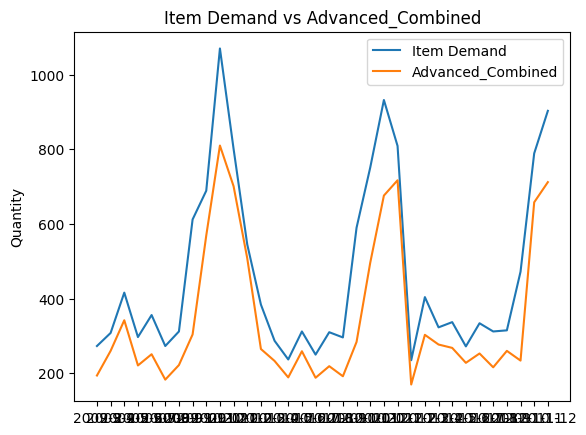

In [104]:
grouped_df = combined_df.groupby(['Order Year', 'Order Month']).agg({'item_demand': 'sum', 'Advanced_Combined': 'sum'}).reset_index()

plt.plot(grouped_df.index, grouped_df['item_demand'], label='Item Demand')
plt.plot(grouped_df.index, grouped_df['Advanced_Combined'], label='Advanced_Combined')

plt.xticks(grouped_df.index, grouped_df['Order Year'].astype(str) + '-' + grouped_df['Order Month'].astype(str))
plt.ylabel('Quantity')
plt.title('Item Demand vs Advanced_Combined')
plt.legend()
plt.show()


In [105]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
avg_actual = y.mean()
mae_ratio = mae / avg_actual
print(f"MAE Ratio: {mae_ratio:.4f}")


Best alpha: 100
Mean Squared Error: 7978.6995
Mean Absolute Error: 64.2405
MAE Ratio: 0.1382


In [106]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

y_pred = model.predict(X)

predictions = pd.DataFrame({'Year': combined_df['Delivery Year'], 'Month': combined_df['Delivery Month'], 'D_Season_Num': combined_df['D_Season_Num'], 'Actual': y, 'Predicted': y_pred})

print(predictions)


    Year  Month  D_Season_Num  Actual   Predicted
2   2009      3             2     273  287.321004
3   2009      4             2     308  356.075613
4   2009      5             2     416  450.007109
5   2009      6             3     297  313.931112
6   2009      7             3     356  347.888823
7   2009      8             3     273  270.049088
8   2009      9             4     312  316.527816
9   2009     10             4     612  409.746803
10  2009     11             4     689  711.833032
11  2009     12             1    1070  993.817436
12  2010      1             1     801  860.052555
13  2010      2             1     545  654.339425
14  2010      3             2     384  363.079224
15  2010      4             2     287  328.985928
16  2010      5             2     237  277.738608
17  2010      6             3     312  352.643735
18  2010      7             3     250  277.793009
19  2010      8             3     310  311.494256
20  2010      9             4     296  281.647582


In [107]:
predictions.head()

,Year,Month,D_Season_Num,Actual,Predicted
2,2009,3,2,273,287.321004
3,2009,4,2,308,356.075613
4,2009,5,2,416,450.007109
5,2009,6,3,297,313.931112
6,2009,7,3,356,347.888823


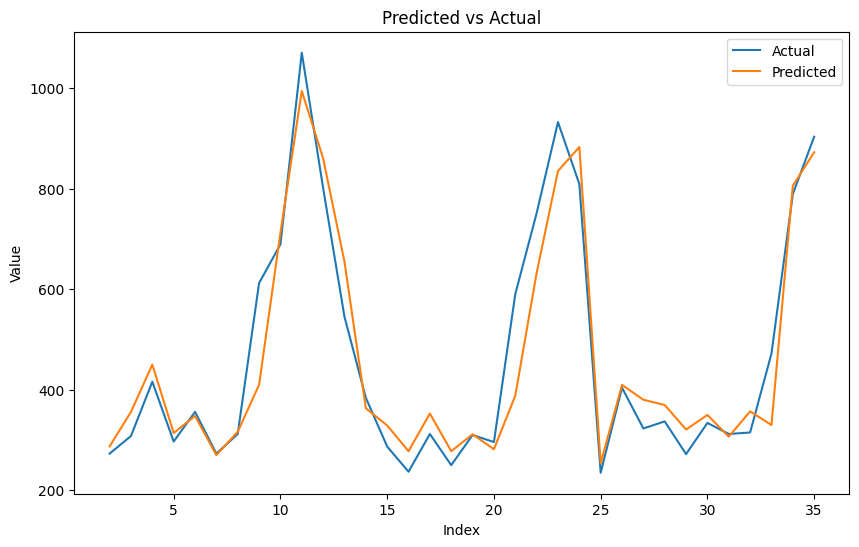

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(predictions['Actual'], label='Actual')
plt.plot(predictions['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()


Now that we have our monthly demand estimates, I will combine them with each seasons product choice probability to find out how the projected demand breaks down to a SKU level.

In [109]:
merged_df = pd.merge(predictions, seasonal_choice_probabilities, left_on='D_Season_Num', right_index=True, how='left')


In [110]:
merged_df.head()

,Year,Month,D_Season_Num,Actual,Predicted,prob_PK001,prob_PK002,prob_PK003,prob_PK004
2,2009,3,2,273,287.321004,0.269208,0.259178,0.239519,0.232096
3,2009,4,2,308,356.075613,0.269208,0.259178,0.239519,0.232096
4,2009,5,2,416,450.007109,0.269208,0.259178,0.239519,0.232096
5,2009,6,3,297,313.931112,0.212815,0.281937,0.224355,0.280893
6,2009,7,3,356,347.888823,0.212815,0.281937,0.224355,0.280893


In [111]:
prob_cols = ['prob_PK001', 'prob_PK002', 'prob_PK003', 'prob_PK004']
new_cols = ['PK001', 'PK002', 'PK003', 'PK004']

for prob_col, new_col in zip(prob_cols, new_cols):
    merged_df[new_col] = round(merged_df[prob_col] * merged_df['Predicted']).astype(int)


In [112]:
merged_df.head(100)

,Year,Month,D_Season_Num,Actual,Predicted,prob_PK001,prob_PK002,prob_PK003,prob_PK004,PK001,PK002,PK003,PK004
2,2009,3,2,273,287.321004,0.269208,0.259178,0.239519,0.232096,77,74,69,67
3,2009,4,2,308,356.075613,0.269208,0.259178,0.239519,0.232096,96,92,85,83
4,2009,5,2,416,450.007109,0.269208,0.259178,0.239519,0.232096,121,117,108,104
5,2009,6,3,297,313.931112,0.212815,0.281937,0.224355,0.280893,67,89,70,88
6,2009,7,3,356,347.888823,0.212815,0.281937,0.224355,0.280893,74,98,78,98
7,2009,8,3,273,270.049088,0.212815,0.281937,0.224355,0.280893,57,76,61,76
8,2009,9,4,312,316.527816,0.263655,0.225561,0.258498,0.252287,83,71,82,80
9,2009,10,4,612,409.746803,0.263655,0.225561,0.258498,0.252287,108,92,106,103
10,2009,11,4,689,711.833032,0.263655,0.225561,0.258498,0.252287,188,161,184,180
11,2009,12,1,1070,993.817436,0.259297,0.235113,0.259113,0.246476,258,234,258,245


In [113]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SARIMAX(y_train, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98703D+00    |proj g|=  1.43003D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  3.98673D+00    |proj g|=  1.64518D-04

At iterate   10    f=  3.98670D+00    |proj g|=  3.35964D-03

At iterate   15    f=  3.98615D+00    |proj g|=  1.74577D-04

At iterate   20    f=  3.98614D+00    |proj g|=  4.53908D-05

At iterate   25    f=  3.98613D+00    |proj g|=  1.05619D-04

At iterate   30    f=  3.98613D+00    |proj g|=  3.71993D-05

At iterate   35    f=  3.98613D+00    |proj g|=  2.85203D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     45      1     0     0   8.900D-05   3.986D+00
  F =   3.9861319817099004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [114]:
y_pred = model_fit.predict()

predictions_sarima = pd.DataFrame({'Month': combined_df['Order Month'], 'Year': combined_df['Order Year'], 'Actual': y, 'Predicted': y_pred})

print(predictions_sarima)


    Month  Year  Actual   Predicted
2       3  2009     273   60.042531
3       4  2009     308   29.921638
4       5  2009     416   23.445499
5       6  2009     297  758.696365
6       7  2009     356   33.569490
7       8  2009     273   20.719511
8       9  2009     312  306.563494
9      10  2009     612  659.381170
10     11  2009     689         NaN
11     12  2009    1070   39.717498
12      1  2010     801  398.033161
13      2  2010     545   19.108396
14      3  2010     384    0.000000
15      4  2010     287   19.146995
16      5  2010     237  506.767071
17      6  2010     312         NaN
18      7  2010     250   27.414393
19      8  2010     310   20.651432
20      9  2010     296  537.430017
21     10  2010     590         NaN
22     11  2010     751  554.173511
23     12  2010     932         NaN
24      1  2011     809  296.673964
25      2  2011     235  -37.145962
26      3  2011     404         NaN
27      4  2011     323  266.526949
28      5  2011     337     

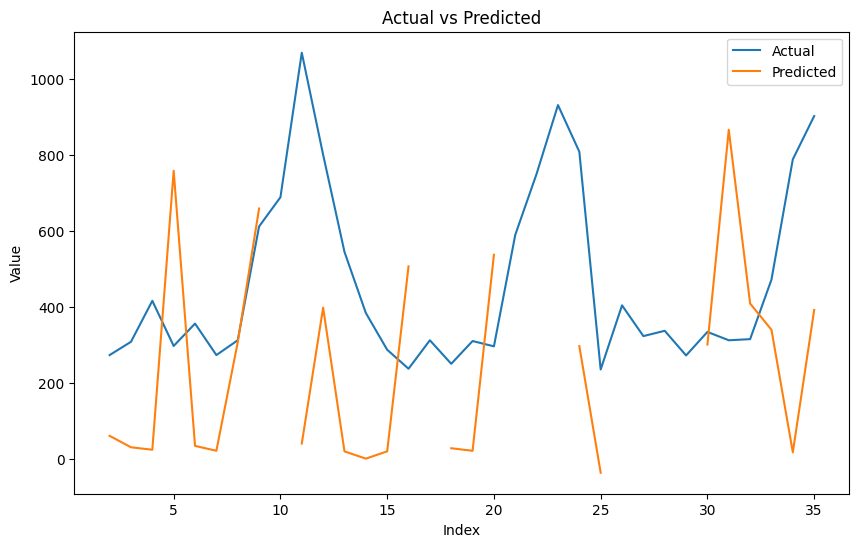

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_sarima['Actual'], label='Actual')
plt.plot(predictions_sarima['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [116]:
combined_df.tail()

,Order Year,Order Month,O_Season_Num,ordered_items,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Delivery Year,Delivery Month,D_Season_Num,item_demand,Urgent_Items_prev_month,Advanced_Urgent_Items_prev_month,Advanced_Items_2_months_ago,Advanced_Combined
31,2011,8,3,397,96,202,99,2011,8,3,312,81.0,163.0,53.0,216.0
32,2011,9,4,228,55,135,38,2011,9,4,315,96.0,202.0,58.0,260.0
33,2011,10,4,1016,238,620,158,2011,10,4,472,55.0,135.0,99.0,234.0
34,2011,11,4,902,131,554,217,2011,11,4,789,238.0,620.0,38.0,658.0
35,2011,12,1,830,191,497,142,2011,12,1,903,131.0,554.0,158.0,712.0


In [117]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)


new_data = pd.DataFrame({'Urgent_Items_prev_month': [combined_df['Urgent_Items_prev_month'].iloc[-1]], 
                         'Advanced_Urgent_Items_prev_month': [combined_df['Advanced_Urgent_Items_prev_month'].iloc[-1]], 
                         'Advanced_Items_2_months_ago': [combined_df['Advanced_Items_2_months_ago'].iloc[-1]]})

prediction = model.predict(new_data)

print(f"Predicted demand for the next month: {prediction[0]:.2f}")


Predicted demand for the next month: 872.23


In [118]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ARIMA(y_train, order=(1, 0, 0))
model_fit = model.fit()

y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

mse = mean_squared_error(y_test, y_pred)
print(mse)


52196.37903790407


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [119]:
y_pred = model_fit.predict()

predictions_arima = pd.DataFrame({'Month': combined_df['Order Month'], 'Year': combined_df['Order Year'], 'Actual': y, 'Predicted': y_pred})

print(predictions_arima)

    Month  Year  Actual   Predicted
2       3  2009     273  617.588839
3       4  2009     308  477.996447
4       5  2009     416  414.980453
5       6  2009     297  416.841685
6       7  2009     356  405.674293
7       8  2009     273  415.512233
8       9  2009     312  418.968807
9      10  2009     612  573.185164
10     11  2009     689         NaN
11     12  2009    1070  542.873673
12      1  2010     801  495.811095
13      2  2010     545  409.396757
14      3  2010     384  453.728150
15      4  2010     287  405.674293
16      5  2010     237  546.064356
17      6  2010     312         NaN
18      7  2010     250  427.743186
19      8  2010     310  399.558817
20      9  2010     296  548.191479
21     10  2010     590         NaN
22     11  2010     751  416.044014
23     12  2010     932         NaN
24      1  2011     809  458.586457
25      2  2011     235  416.044014
26      3  2011     404         NaN
27      4  2011     323  411.789770
28      5  2011     337     

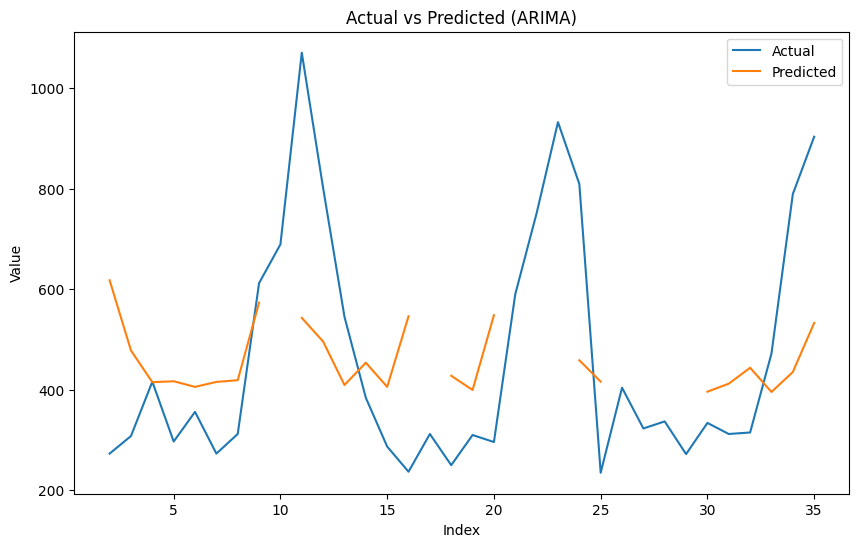

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_arima['Actual'], label='Actual')
plt.plot(predictions_arima['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (ARIMA)')
plt.legend()
plt.show()
